In [1]:
import glob
import os, sys
import pandas as pd

BLAST_PATH="/wynton/home/ahituv/fongsl/nullomers/data/mpra/blast/" 
CSV = "/wynton/home/ahituv/fongsl/nullomers/data/mpra/PromoterNullomer_ABV20.csv"

# open original dataframe 

In [2]:
def formatInsertDf(csv):
    
    """
    format the orignal insert dataframe and calculate insert lengths
    
    input
        csv (str) - full path to .csv insert file from Ofer.
    
    method 
        1. read the csv file w/ select columns
            - ID_ORIG (int) - insert id
            - INSERT (str) - insert sequence
            - CATEGORY (str) - Nullomer, control scramble, control frequent kmer (aka knownmers)
            - expression (str) - categorical
                scrm_expression = case_when(log2(avg) >= log(2) & pv_scrm <= 0.05 ~ “Up-regulated”,
                           log2(avg) <= -log(2) & pv_scrm <= 0.05 ~ “Down-regulated”,
                           TRUE ~ “Unchanged”))
            - Rep_count (int) - n replicates

        2. calculate the length of the insert
        
        3. get knowmer subset
            - rep count = 3
            - category = control_freq
            
        4. get nullomer subset
            - rep count = 3
            - category = nullomer
            - expression != Unchanged
            
        5. make dictionary of insert id, length
        
        6 concatenate knownmer and nullomer subsets
        
    return
        concat (pd dataframe obj) - dataframe of nullomer and knownmer stats
        len_dict (dictionary) - dictionary of insert_id:insert length
        
    """
    #1
    insert_df = pd.read_csv(CSV, usecols=["ID_ORIG", "INSERT", "CATEGORY", "expression", "Rep_count"])
    
    #2
    insert_df["len"]=insert_df["INSERT"].str.len()  # get length of insert

    #3
    knownmers = insert_df.loc[
                        (insert_df["Rep_count"]==3)
                        & (insert_df["CATEGORY"] =="CONTROL_FREQ")
                        ]
    
    #4
    nullomers = insert_df.loc[
                        (insert_df["Rep_count"]==3)
                        & (insert_df["CATEGORY"] =="NULLOER")
                        & (insert_df["expression"]!="Unchanged")
                        ]
    
    #5 dictionary of ids: insert lengths
    
    len_dict = insert_df[["ID_ORIG", "len"]].copy().drop_duplicates().set_index('ID_ORIG')['len'].to_dict()
    
    #6
    concat = pd.concat([knownmers, nullomers]) # concat the dataframes together
    
    return concat, len_dict

In [3]:
insert_df, len_dict = formatInsertDf(CSV)

# functions open blast files

In [4]:
def openBlastTxt(file):
    
    cols = ["query acc.ver", 
        "subject acc.ver", "% identity", "alignment length",
        "mismatches", "gap opens",
        "q. start", "q. end", "s. start", "s. end",
        "evalue", "bit score"]

    df = pd.read_csv(file, sep='\t', comment='#', header = None, names=cols)
    
    return df

In [5]:
def countHits(df, len_dict):

    # count the total number of hits per mer
    
    hit_dict = {}

    for i in df["query acc.ver"].unique():
        
        test = df.loc[df["query acc.ver"]==i].copy()   # subset the dataframe
        
        ID = test["dataset"].iloc[0]  # is this nullomer or knownmer? 
        
        insert_len = len_dict[i] # get insert legnth
        
        n_total_hits = test.shape[0]  # count the total number of hits

        perfect_hits = test.loc[
                                (test["len_dif"]==0)
                                & (test["mismatches"]==0)
                                & (test["gap opens"]==0)
                                &(test["% identity"]==100)
                               ].shape[0]  # count the perfect number of hits (length dif is zero)
        
        hit_dict[i] = (ID, n_total_hits, perfect_hits, (perfect_hits/n_total_hits))
        
    return hit_dict

#  open blast file

In [6]:
file_identity = ["knownmer", "nullomer"]
fs = glob.glob(os.path.join(BLAST_PATH, "*"))

collection_dict = {}

for file, file_id in zip(fs, file_identity):
    df  = openBlastTxt(file)
    df["dataset"] = file_id
    collection_dict[file_id] = df

# add insert info to dataframe. 
bdf = pd.concat(collection_dict.values())

bdf = pd.merge(bdf, insert_df, how= "left", left_on="query acc.ver", right_on='ID_ORIG')

bdf["len_dif"] = bdf["alignment length"] - bdf["len"] # if zero, perfect match

bdf.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,dataset,ID_ORIG,CATEGORY,INSERT,Rep_count,expression,len,len_dif
0,46077,NW_021160017.1,100.0,15,0,0,1,15,1113,1099,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
1,46077,NW_021160017.1,100.0,15,0,0,1,15,3667,3653,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
2,46077,NW_021160017.1,100.0,15,0,0,1,15,3838,3824,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
3,46077,NW_021160017.1,100.0,15,0,0,1,15,7072,7058,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
4,46077,NW_021160017.1,100.0,15,0,0,1,15,8778,8764,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0


# count the number of perfect matches 

In [7]:
hit_dict = countHits(bdf, len_dict)

hit_dict

{46077: ('knownmer', 31885, 19545, 0.6129841618315822),
 46086: ('knownmer', 26361, 19512, 0.7401843632639126),
 46089: ('knownmer', 111, 107, 0.963963963963964),
 46095: ('knownmer', 114, 101, 0.8859649122807017),
 46098: ('knownmer', 114, 101, 0.8859649122807017),
 46104: ('knownmer', 146, 105, 0.7191780821917808),
 46125: ('knownmer', 202, 134, 0.6633663366336634),
 46134: ('knownmer', 112, 108, 0.9642857142857143),
 46140: ('knownmer', 102, 102, 1.0),
 46152: ('knownmer', 105, 103, 0.9809523809523809),
 46170: ('knownmer', 113, 108, 0.9557522123893806),
 46171: ('knownmer', 113, 108, 0.9557522123893806),
 46179: ('knownmer', 102, 101, 0.9901960784313726),
 46185: ('knownmer', 148, 102, 0.6891891891891891),
 46188: ('knownmer', 148, 102, 0.6891891891891891),
 46189: ('knownmer', 148, 102, 0.6891891891891891),
 46197: ('knownmer', 104, 100, 0.9615384615384616),
 46200: ('knownmer', 104, 100, 0.9615384615384616),
 46203: ('knownmer', 36596, 19960, 0.5454147994316318),
 46214: ('knownm

# blast stats

In [9]:
bdf.describe()

,query acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,ID_ORIG,Rep_count,len,len_dif
count,2.637984e+06,2.637984e+06,2.637984e+06,2.637984e+06,2637984.0,2.637984e+06,2.637984e+06,2.637984e+06,2.637984e+06,2.637984e+06,2.637984e+06,2.637984e+06,2637984.0,2.637984e+06,2.637984e+06
mean,4.680245e+04,9.999998e+01,1.366109e+01,2.653541e-06,0.0,1.592794e+00,1.425389e+01,4.587668e+07,4.587668e+07,1.417117e+02,2.756990e+01,4.680245e+04,3.0,1.499986e+01,-1.338769e+00
std,1.684910e+03,1.086033e-02,1.301341e+00,1.628968e-03,0.0,1.063947e+00,1.093455e+00,3.338991e+07,3.338991e+07,1.704364e+02,2.555578e+00,1.684910e+03,0.0,1.670274e-02,1.301274e+00
min,4.607700e+04,9.333300e+01,1.200000e+01,0.000000e+00,0.0,1.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,6.400000e+00,2.430000e+01,4.607700e+04,3.0,1.300000e+01,-3.000000e+00
25%,4.647000e+04,1.000000e+02,1.200000e+01,0.000000e+00,0.0,1.000000e+00,1.300000e+01,1.933850e+07,1.933850e+07,6.400000e+00,2.430000e+01,4.647000e+04,3.0,1.500000e+01,-3.000000e+00
50%,4.675300e+04,1.000000e+02,1.400000e+01,0.000000e+00,0.0,1.000000e+00,1.500000e+01,3.822807e+07,3.822806e+07,2.500000e+01,2.820000e+01,4.675300e+04,3.0,1.500000e+01,-1.000000e+00
75%,4.704900e+04,1.000000e+02,1.500000e+01,0.000000e+00,0.0,2.000000e+00,1.500000e+01,5.913308e+07,5.913307e+07,3.980000e+02,3.020000e+01,4.704900e+04,3.0,1.500000e+01,0.000000e+00
max,1.640800e+05,1.000000e+02,1.500000e+01,1.000000e+00,0.0,4.000000e+00,1.500000e+01,2.488604e+08,2.488604e+08,3.980000e+02,3.020000e+01,1.640800e+05,3.0,1.500000e+01,0.000000e+00


In [21]:
bdf.groupby(["query acc.ver", "CATEGORY"])["mismatches"].count().reset_index()

,query acc.ver,CATEGORY,mismatches
0,46077,CONTROL_FREQ,31885
1,46086,CONTROL_FREQ,26361
2,46089,CONTROL_FREQ,111
3,46095,CONTROL_FREQ,114
4,46098,CONTROL_FREQ,114
...,...,...,...
294,161529,NULLOER,1
295,161920,NULLOER,1
296,162330,NULLOER,3
297,163440,NULLOER,15


## how many mismatch records? 

In [8]:
# all frequent mers
bdf.loc[bdf["mismatches"]==1]

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,dataset,ID_ORIG,CATEGORY,INSERT,Rep_count,expression,len,len_dif
863514,46527,NC_000001.11,93.333,15,1,0,1,15,121757474,121757460,398.0,24.3,knownmer,46527,CONTROL_FREQ,GACTTTACAAACAGA,3,Unchanged,15.0,0.0
863515,46527,NC_000001.11,93.333,15,1,0,1,15,121966039,121966025,398.0,24.3,knownmer,46527,CONTROL_FREQ,GACTTTACAAACAGA,3,Unchanged,15.0,0.0
893152,46532,NC_000001.11,93.333,15,1,0,1,15,121757460,121757474,398.0,24.3,knownmer,46532,CONTROL_FREQ,TCTGTTTGTAAAGTC,3,Unchanged,15.0,0.0
893153,46532,NC_000001.11,93.333,15,1,0,1,15,121966025,121966039,398.0,24.3,knownmer,46532,CONTROL_FREQ,TCTGTTTGTAAAGTC,3,Unchanged,15.0,0.0
993262,46651,NC_000001.11,93.333,15,1,0,1,15,121757473,121757459,398.0,24.3,knownmer,46651,CONTROL_FREQ,ACTTTACAAACAGAG,3,Unchanged,15.0,0.0
993264,46651,NC_000001.11,93.333,15,1,0,1,15,121966038,121966024,398.0,24.3,knownmer,46651,CONTROL_FREQ,ACTTTACAAACAGAG,3,Unchanged,15.0,0.0
1204421,46707,NC_000001.11,93.333,15,1,0,1,15,121966023,121966037,398.0,24.3,knownmer,46707,CONTROL_FREQ,ACTCTGTTTGTAAAG,3,Unchanged,15.0,0.0


In [14]:
list(bdf)

['query acc.ver',
 'subject acc.ver',
 '% identity',
 'alignment length',
 'mismatches',
 'gap opens',
 'q. start',
 'q. end',
 's. start',
 's. end',
 'evalue',
 'bit score',
 'dataset',
 'ID_ORIG',
 'CATEGORY',
 'INSERT',
 'Rep_count',
 'expression',
 'len',
 'len_dif']

# plot perfect hits

In [9]:
# transpose the dataframe from the dictionary
t = pd.DataFrame.from_dict(hit_dict).T

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# rename columns
t.columns = ["id", "total_hits", "perfect_hits", "%perfect_hits"]

t.head()

,id,total_hits,perfect_hits,%perfect_hits
46077,knownmer,31885,19545,0.612984
46086,knownmer,26361,19512,0.740184
46089,knownmer,111,107,0.963964
46095,knownmer,114,101,0.885965
46098,knownmer,114,101,0.885965


[Text(0.5, 0, 'fraction perfect matches'),
 Text(0.5, 1.0, '% perfect blastn matches')]

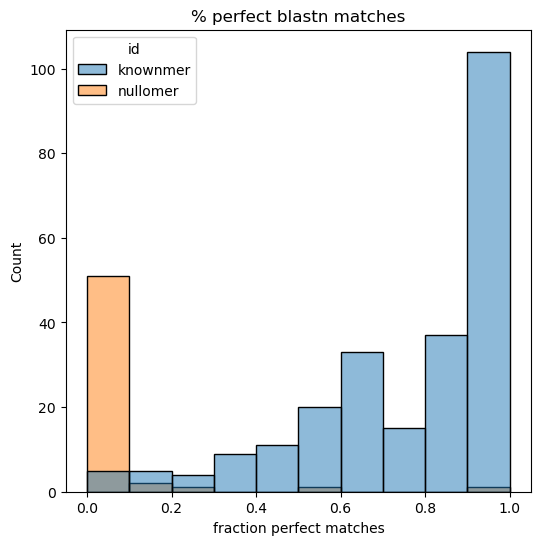

In [19]:
fig, ax = plt.subplots(figsize =(6,6))
sns.histplot(x = "%perfect_hits", data=t, hue="id")
ax.set(xlabel="fraction perfect matches",
      title = "% perfect blastn matches")

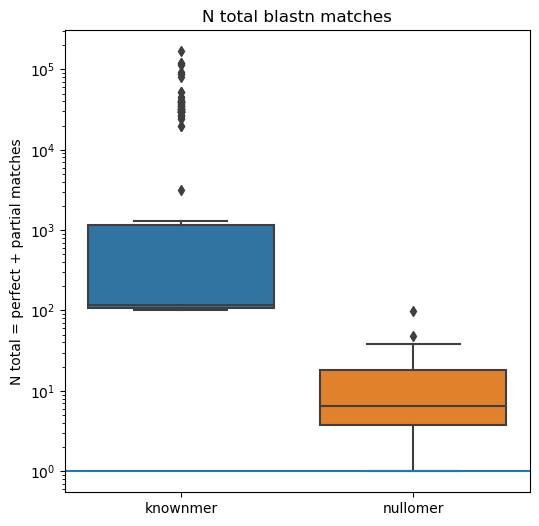

In [14]:
fig, ax = plt.subplots(figsize =(6,6))
sns.boxplot(x = "id", y="total_hits", data=t)
ax.set(
    xlabel="",
    ylabel="N total = perfect + partial matches",
      title = "N total blastn matches")
ax.axhline(1)
ax.set_yscale('log')

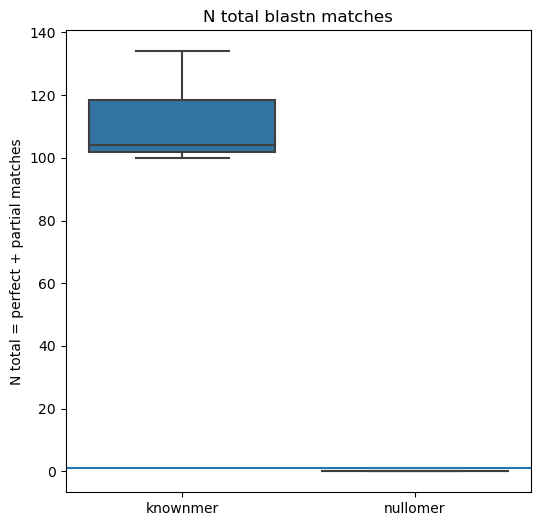

In [24]:
fig, ax = plt.subplots(figsize =(6,6))
sns.boxplot(x = "id", y="perfect_hits", data=t,
            #showfliers=False
           )
ax.set(
    xlabel="",
    ylabel="N total = perfect + partial matches",
      title = "N total blastn matches")
ax.axhline(1)
#ax.set_yscale('log')

In [25]:
t.loc[(t["id"]=="knownmer") 
      &(t["perfect_hits"]==0)
     ]

,id,total_hits,perfect_hits,%perfect_hits


[Text(0.5, 0, ''),
 Text(0, 0.5, '% perfect matches'),
 Text(0.5, 1.0, '% perfect blastn matches')]

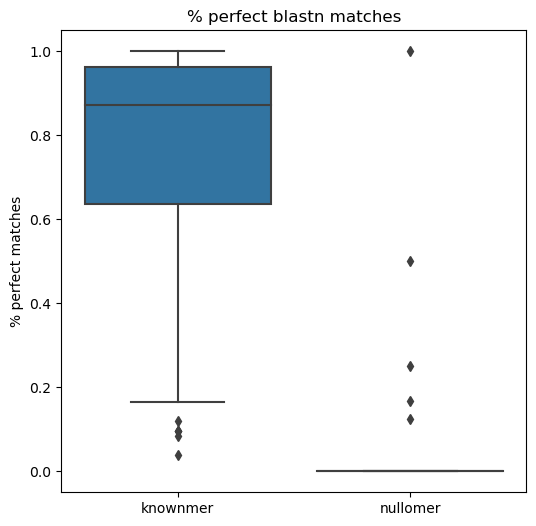

In [18]:
fig, ax = plt.subplots(figsize =(6,6))
sns.boxplot(x = "id", y="%perfect_hits", data=t)
ax.set(
    xlabel="",
    ylabel="% perfect matches",

      title = "% perfect blastn matches")
#ax.axhline(1)
#ax.set_yscale('log')

In [20]:
bdf.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,dataset,ID_ORIG,CATEGORY,INSERT,Rep_count,expression,len,len_dif
0,46077,NW_021160017.1,100.0,15,0,0,1,15,1113,1099,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
1,46077,NW_021160017.1,100.0,15,0,0,1,15,3667,3653,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
2,46077,NW_021160017.1,100.0,15,0,0,1,15,3838,3824,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
3,46077,NW_021160017.1,100.0,15,0,0,1,15,7072,7058,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0
4,46077,NW_021160017.1,100.0,15,0,0,1,15,8778,8764,6.4,30.2,knownmer,46077,CONTROL_FREQ,AAAATCTAGACAGAA,3,Unchanged,15.0,0.0


In [25]:
t.loc[(t["%perfect_hits"]>0) & (t["id"]=="nullomer")]

,id,total_hits,perfect_hits,%perfect_hits
154195,nullomer,6,1,0.166667
158600,nullomer,4,1,0.25
158347,nullomer,8,1,0.125
161920,nullomer,1,1,1.0
159600,nullomer,4,2,0.5
